
---
<big><big><big><big><big><big>Metody uczenia maszynowego</big></big></big></big></big></big>

---



---
<big><big><big><big><big>Drzewa klasyfikacyjne</big></big></big></big></big>

---


---

<id=tocheading><big><big><big><big>Spis treści</big></big></big></big>
<div id="toc"></div>

---


In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [6]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2.5)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.style.use("fivethirtyeight")

from bokeh.io import gridplot, output_file, show
from bokeh.plotting import figure, output_notebook
from bkcharts import Scatter

In [109]:
from __future__ import print_function
from __future__ import unicode_literals
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression, make_blobs
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

In [8]:
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples, completeness_contamination

In [9]:
output_notebook()
sns.set(font_scale=2.5)

Loading BokehJS ...

Image inclusion
<img src="../mum_figures/" width="0%">

<img style="fill=right" src="../mum_figures/" width="0%">

# Drzewa decyzyjne
1. model dyskryminacyjny
2. granice decyzyjne __hierarchiczne__
  * struktura drzewa
  * sekwencja binarnych testów __tak__/__nie__
3. każdy test na __pojedynczym__ atrybucie
  * szybka budowa
  * dobra interpretowalność
    * prosta ekstrakcja cech
    
4. __binarne drzewa klasyfikacjne__
5. __drzewa regresji i klasyfikacji__ 
  * _classification and regression trees CART_ (Breiman od 1984)
  * podobne modele ID3, C4.5, C5.0 (Quinlan, od 1986)

## Klasyfikacja danych astronomicznych
1. klasyfikacja gwiazdy stałe / typ pulsujących gwiazd zmiennych (RR Lyrae)
  * okres od $0.2$ do $1.2$ dnia
2. obserwacje z bazy danych Sloan Digital Sky Survey [SDSS](http://www.sdss.org)
3. $92 658$ gwiazd niezmiennych / 483 pulsujące
4. opisane w przestrzeni kolor-kolor (w astronomii różne filtry opisujące m.in. temperaturę)
  * $0.70<u-g<1.35$
  * $-0.15<g-r<0.40$
  * $-0.15<r-i<0.22$
  * $-0.21<i-z<0.25$

<img src="../mum_figures/ll_lyrae.jpg" width="100%"/>

<img src="../mum_figures/ll_lyrae_dt.png" width="80%"/>

<img src="../mum_figures/ll_lyrae_dt_results.png" width="90%"/>

## Budowa drzewa
1. podział __hiper-płaszczyznami równoległymi__ do osi układu współrzędnych
  * równoległość może być problemem
    * co jeśli dane idą po przekątnej?
2. wybór atrybutu do testu
  * wybór wartości dzielącej
  * testu i podział zbioru danych
3. powtórka aż do siągnięcia warunku końca __niezależnie__ dla każdego z poddrzew
    * wszystkie przykłady w jednym węźle należą do jednej klasy
      * albo większość
    * liczba przykładów w węzłach poniżej minimum
    * liczba poziomów drzewa powyżej maksimum
4. każdy podział to w zasadzie osobny model
5. klasyfikacja przykładów
  * wykonanie testów według drzewa i wyników
  * klasyfikacja według liścia w którym przykład wyląduje
    * każdy liść związany z jedną etykietą klasy 
    * głosowanie według przykładów w lisciu w trakcie uczenia
          
6. __podstawowe problemy__
  * najlepszy sposób wyboru testów?
  * kiedy przerwać tworzenie testów w danym poddrzewie?
  * jak związać liść z odpowiedzią?

## Kryterium podziału węzłów
1. __test $x_i<t$__ 
  * dla dyskretnych odpowiada to wyborowi pewnego podzbioru wartości
  * każdy dzieli $X$ na __rozłączne__ podzbiory $\{x:x<t\}$ i $\{x:x\geq t\}$
2. założenie
  * podział na $\{x:x<t\}$ oraz $\{x:x\geq t\}$ __bardziej homogeniczne__ niż ich suma
  * __homogeniczne__ czyli bardziej spójne jeśli chodzi o klasyfikację
3. przykłady w __podzbiorach__ częściej należą do podzbioru __klas__
4. procedura
  * zmierzyć __zanieczyszczenie__ (niejednorodność, impurity, contamination) zbioru __przed podziałem__
  * wybrać taki test, że oczekiwana jednorodność w podzbiorach __po podziale_ zwiększy się w największym stopniu__

## Możliwe testy
1. __entropia__ 
  $$\boxed{H(x)=-\sum_{k=1}^KP(c_k\mid x)\,\log_2P(c_k\mid x)\;}$$
  * wykorzystywana w drzewach klasyfikacji ID3, C4.5, C5.0
  * __największa__ niejednorodność gdy prawdopodobieństwa wszystkich klas są równe
  * __najmniejsza__ gdy prawdopodobieństwo dla jednej klasy wynosi $1$
  * __entropia ważona po podziale__ 
  $$\widetilde{H}(t)=\frac{\mid\{x:x<t\}\mid}{\mid\{x\}\mid}H(\{x:x<t\})+\frac{\mid\{x:x\geq t\}\mid}{\mid\{x\}\mid}H(\{x:x\geq t\})$$
  gdzie $t$ jest _progiem_
   * wybrać test którego __zysk informacyjny__ (_infromation gain_) 
   $$IG(x\mid t)=H(t)-\widetilde{H}(t)$$ 
    jest __największy__ 
    $$IG(x\mid t)=H(t)-\underset{s}{\arg\max}\left(\frac{\mid\{x:x<s\}\mid}{\mid\{x\}\mid}H(\{x:x<s\})+\frac{\mid\{x:x\geq s\}\mid}{\mid\{x\}\mid}H(\{x:x\geq s\})\right)$$
        
2. __indeks Giniego__ (_Gini impurity_)
    $$\boxed{I(x)=\sum_{k=1}^KP(c_k\mid t)(1-P(c_k\mid t))\;}$$
  * głównie drzewa regresji
  * ekstrema w tych samych miejscach
  * bardziej wyraźne maksimum

3. __błąd klasyfikacji__ $$1-P(c_k\mid t)$$
  * którą z funkcji wybrać?

4. entropia i Gini są bardziej czułe na zmianę liczby przykładów


> UWAGA: __współczynnik Giniego__ (_Gini coefficient_) wykorzystywany jako miara nierównomiernego (koncentracji) podziału dóbr, to _inna_ miara!

> W USA ok. 0.45, w Polsce ok. 0.3 (mniej więcej w połowie skali w UE).

In [19]:
def entropy_gini():
    def entropy(x):
        return 0.5 * (-x * np.log2(x) - (1 - x) * np.log2(1 - x))
    def gini(x):
        return 2.0 * x * (1.0 - x) 
    def misclassification(x):
        return np.minimum(1 - x, x)

    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.linspace(0.0001, 0.999, 1000)
    ax.plot(x, entropy(x), label='Entropia')
    ax.plot(x, gini(x), label='Indeks Giniego')
    ax.plot(x, misclassification(x), label='Błąd klasyfikacji')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([0.0, 0.51])
    ax.legend(loc='best')

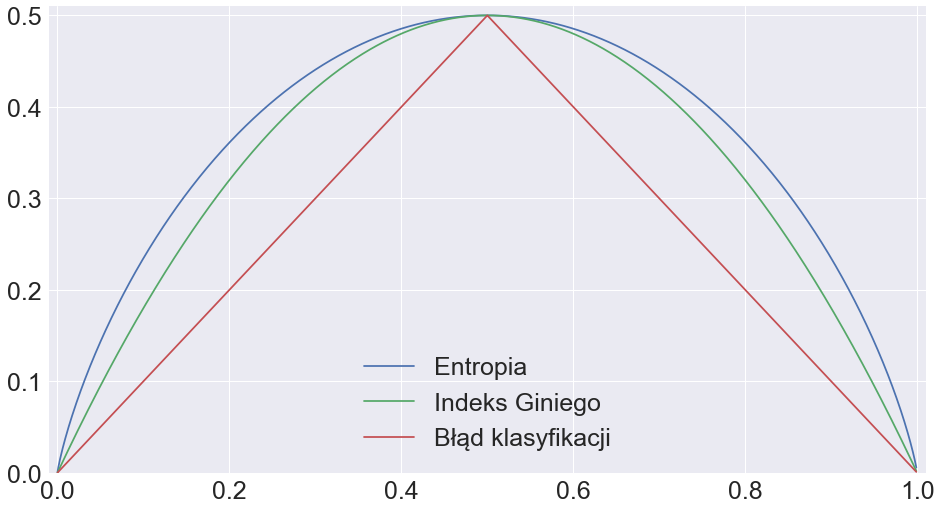

In [20]:
entropy_gini()

### Budowa drzewa
1. dla zmiennych dyskretnych 
  * określenie wszystkich możliwych podziałów na podzbiory wartości
  * wybór optymalnego
2. dla ciągłych znalezienie progu
  * posortować wartości $x$ dla danego atrybutu
  * wygenerować punkty podziału __pośrodku__ miedzy kolejnymi sanymi
  * znaleźć niejednorodność dla każdego progu 
  * wybór optymalnego
3. wszystkie operacje dla __wszystkich__ atrybutów

## Kryterium stopu
1. drzewo przestaje rosnąć 
  * węzły są całkowicie homogeniczne
2. zysk informacyjny poniżej ustalonego progu
  * przykłady z jednej klasy znacznie przeważają w liściach
3. liczności przykładów w liściach poniżej ustalonego progu
  * dalszy podział nie ma sensu, ponieważ model będzie źle generalizował

## Przypisanie węzłów
1. zwykle reguła większościowa

## Ograniczanie głębokości i obcinanie (pruning) drzew
1. zwiększanie złożonosci prowadzi do nadmiernego dopasowania
  * wraz ze wzrostem głębokości maleje błąd
  * przy zbyt dużych głębokościach drzewa odwzorowywują __szum__ w danych
  * konieczne użycie walidacji krzyżowej
    * wyznacznikiem maksymalnej głębokości może być gdy __błąd walidacji _odchodzi_ od spadającego błędu na danych trenujących__

2. podejścia
  * zbudować drzewo pełne
    * pojedyncze podziały mogą dawać niewielki zysk informacyjny
      * jednak rzeczywisty zysk widoczny __po wielu__ podziałach
    * jednak zysk po szeregu podziałów jest już istotny
    * stąd budowa pełnego drzewa __może__ być opłacalne
  * hierarchicznie __łączyć__ liście używając pewnego kryterium stopu
    * oceniając prawdopodobieństwo błędu przypisania
    * wykorzystując odpowiedni zbiór walidacyjny
    * biorąc pod uwagę miarę złożoności modelu
  * do obcinania drzewa __najlepiej__ użyć __danych walidujących__

## Zadania i problemy
---
### zmienne nominalne
---
1. dla $M$ wartości jest $2^{M-1}-1$ możliwych binarnych podziałow 
2. prościej w problemie binarnym
  * posortować wartości według prawdopodobieństwa przypadania do klasy 1
  * teraz rozwiązać zadania jakby atrybut był uporządkowany
    * dowód nietrywialny
3. dla wieloklasowego problemu nie ma prostych rozwiązań
  * przybliżenia, heurezy
  
  
### brakujące atrybuty
---
1. opuszczanie przykładów z brakującymi atrybutami
  * zwykle osłabia zbiór uczący
2. wypełnienie wartości brakujących
  * średnią (czy medianą) z wszystkich przykładów
    * może wprowadzać fałszywe wartości
  * dla zmiennych kategorycznych wprowadzenie wartości __missing__
    * pozwoli na wykrycie reguł zachowania
3. wprowadzenie __zmiennych zastępczych__
    * przy wyborze testów wykorzystywane są przykłady ze zmiennymi pełnymi
    * dla danych brakujących tworzona jest lista predyktorów __zastępczych__
      * pierwszy najlepiej udający podział dla danych oryginalnych
      * drugi najlepszy, itd.

          
### czemu podziały binarne?
---
1. podział na większą liczbę skróciłby drzewo
2. jednak liczba przykładów w klasie zbyt szybko by spadła


### podziały dla kombinacji liniowych atrybutów
---
* może wspomóc uczenie
* osłabia interpretowalność

## Cechy drzew decyzyjnych
1. łatwa obsługa zbiorów z różnymi typami danych (ciągłymi, dyskretnymi, nominalnymi)
2. prosta obsluga przykładów z danymi brakującymi
  * dane mogą być brakujące także gdy są kosztowne
3. łatwa interpretowalność
  * słaba stabilność obniża jakość interpretowalności
4. __słabsza__ generalizacja w porównaniu z innymi modelami
5. podziały wzdłuż współrzędnych mogą być bardzo nieoptymalne
  * wykluczają przecięcia "na ukos"
  * możliwy preprocessing danych dla ich odpowiedniego obrotu, np. PCA
    * może osłabić interpretowalność

6. drzewa są __mało stabilne__
  * budowa drzewa __bardzo__ zależy od zbioru uczącego
  * niewielka zmiana może spowodować dużą zmianę drzewa i predykcji
    * podejścia __bagging__ i __random forests__
    
7. możliwa budowa __drzew regresji__ 
$$\boxed{\widehat{f}(x)=\sum_{R_i}\overline{y}_{i}I(x\in{}R_i)\;}$$
  * budowa drzewa podobna
    * miarą odpowiadającą czystości węzłów jest suma kwadratów residuuów w węźle
  * wartością wyjściową liścia jest średnia przykładów w nim
    * użycie $\overline{y}_i$ minimalizuje błąd średniokwadratowy
    * wyjściowa funkcja $\widehat{f}$ jest schodkowa
  * ewentualnie prosta regresja
    * zwykle trudne ze względu na małą liczbę przykładów
    
    
8. Drzewa decyzyjne w czystej postaci __nie są__ wystarczająco dobrymi klasyfikatorami

In [43]:
def decision_tree_classifier(n_samples=100, centers=2, min_samples_leaf=1,
                       max_depth=None, odds='odds'):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=1.0)
    cls = DecisionTreeClassifier(criterion='gini',max_features='auto',
                                 max_depth=max_depth, 
                                 min_samples_leaf=min_samples_leaf)
    cls.fit(X, y)
    colors = plt.cm.Set2
    fig_lines = (centers + 2) // 2
    fig, ax = plt.subplots(fig_lines, 2, figsize=(18, fig_lines * 8))

    h=0.025
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax[0, 0].pcolormesh(xx, yy, Z, cmap=colors)
    ax[0, 0].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=colors)
    ax[0, 0].set_xlim(xx.min(), xx.max())
    ax[0, 0].set_ylim(yy.min(), yy.max())
    ax[0, 0].set_xticks(())
    ax[0, 0].set_yticks(())
    
    # odds lub log-odds dla poszczegolnych klas
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    for n in range(centers):
        if odds == 'odds':
            Z = cls.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        elif odds == 'log':
            Z = cls.predict_log_proba(np.c_[xx.ravel(), yy.ravel()])[:, n]
        Z = Z.reshape(xx.shape)
        row = (n + 1) // 2; col = (n + 1) % 2
        ax[row, col].pcolormesh(xx, yy, Z, cmap=colors)

        ax[row, col].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', 
                             cmap=colors)
        ax[row, col].set_xlim(xx.min(), xx.max())
        ax[row, col].set_ylim(yy.min(), yy.max())
        ax[row, col].set_xticks(())
        ax[row, col].set_yticks(())
    
    plt.tight_layout()

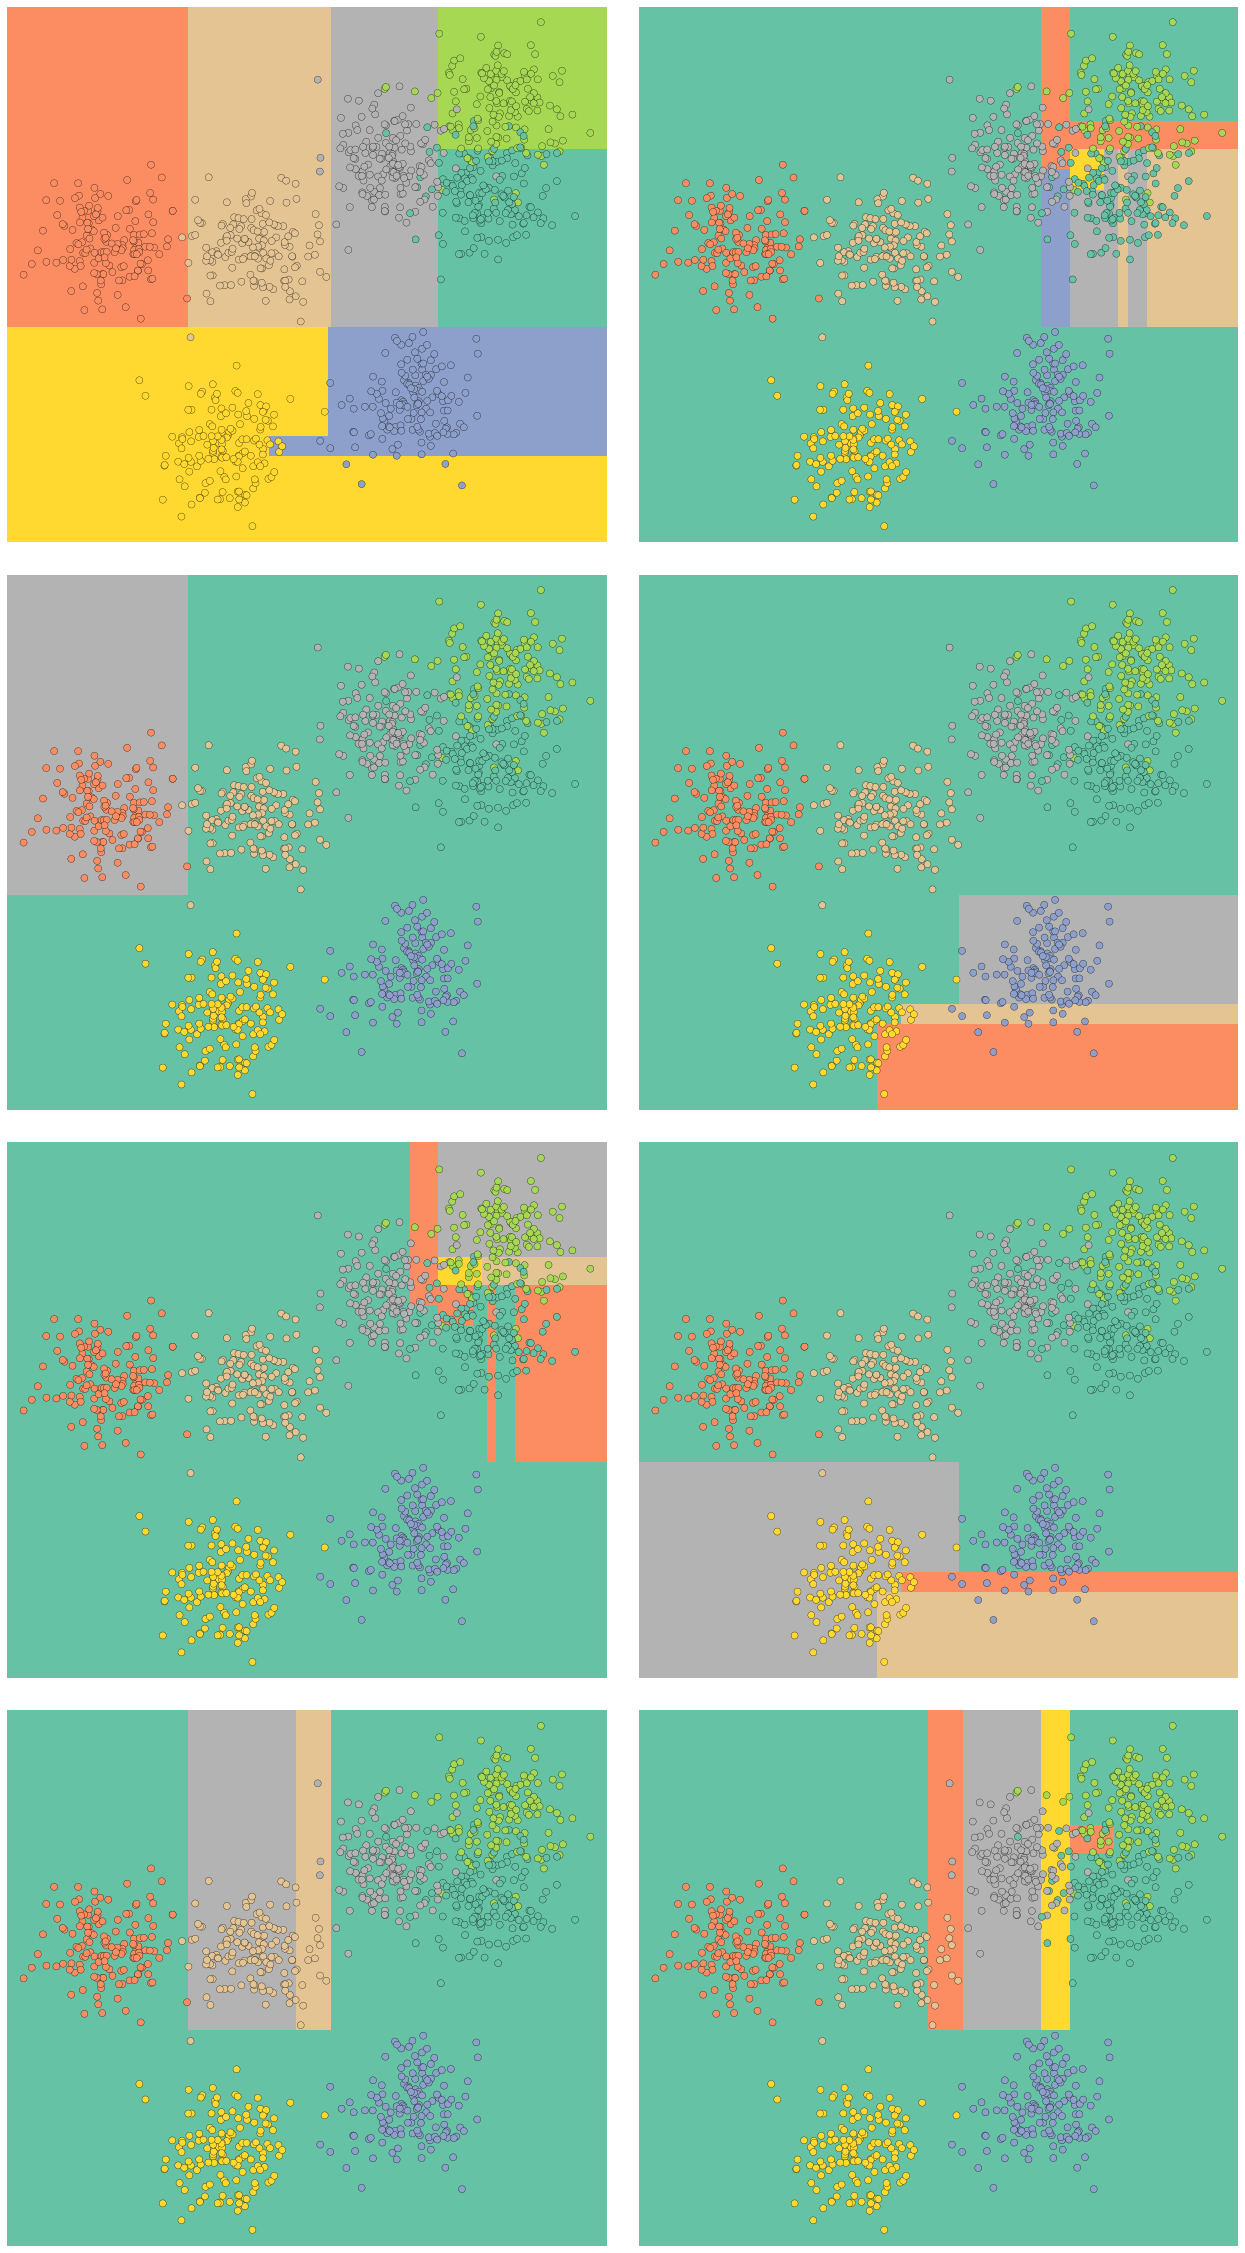

In [45]:
decision_tree_classifier(n_samples=1000, centers=7, min_samples_leaf=17, odds='odds')

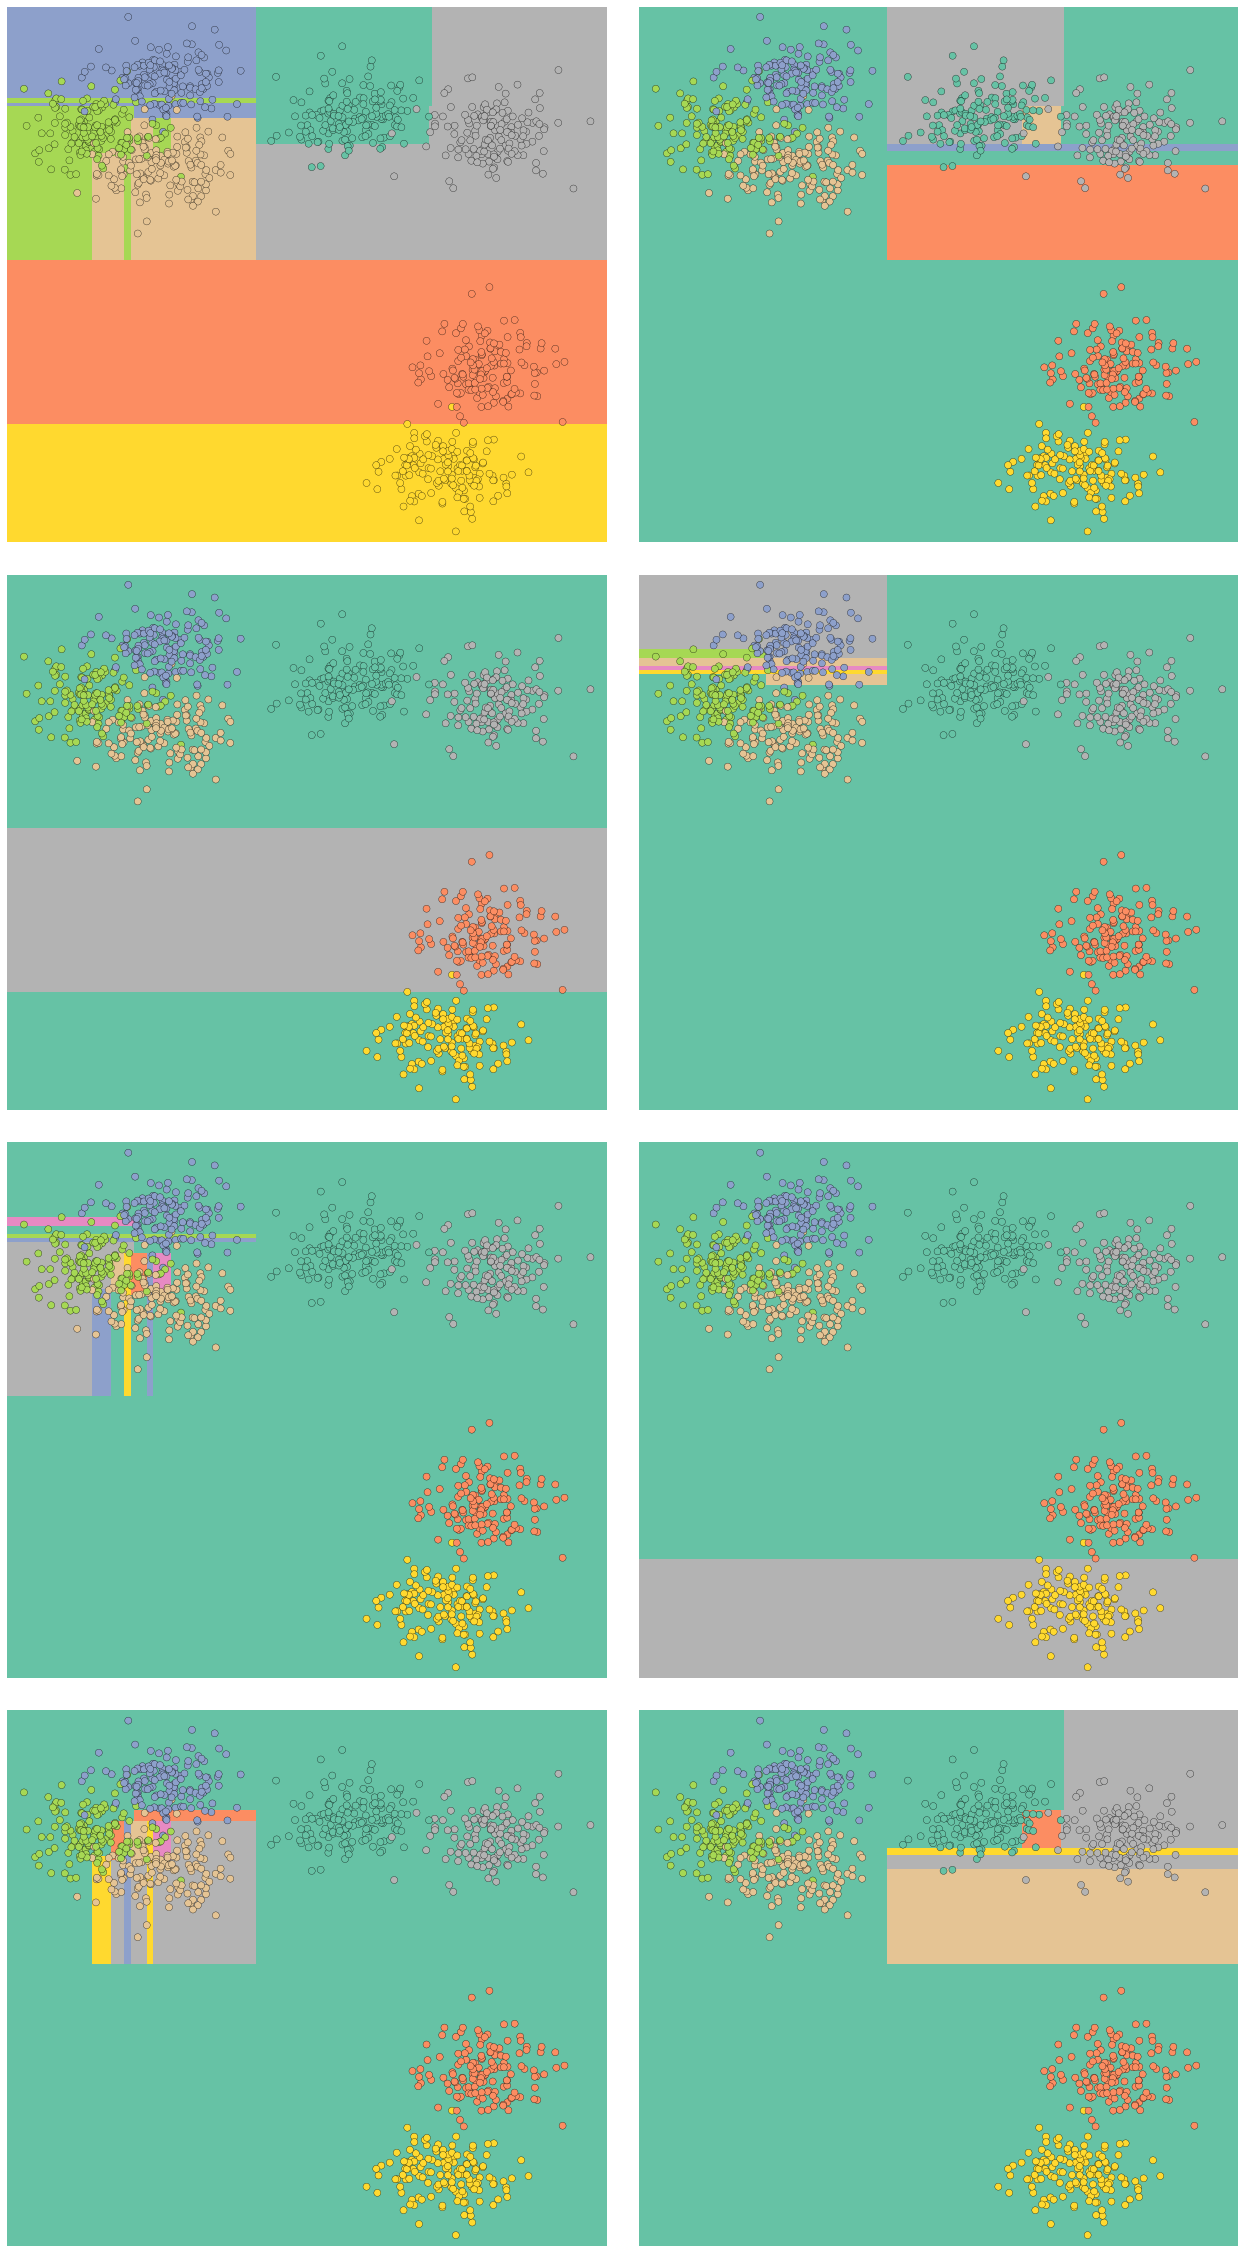

In [46]:
decision_tree_classifier(n_samples=1000, centers=7, min_samples_leaf=11, odds='odds')

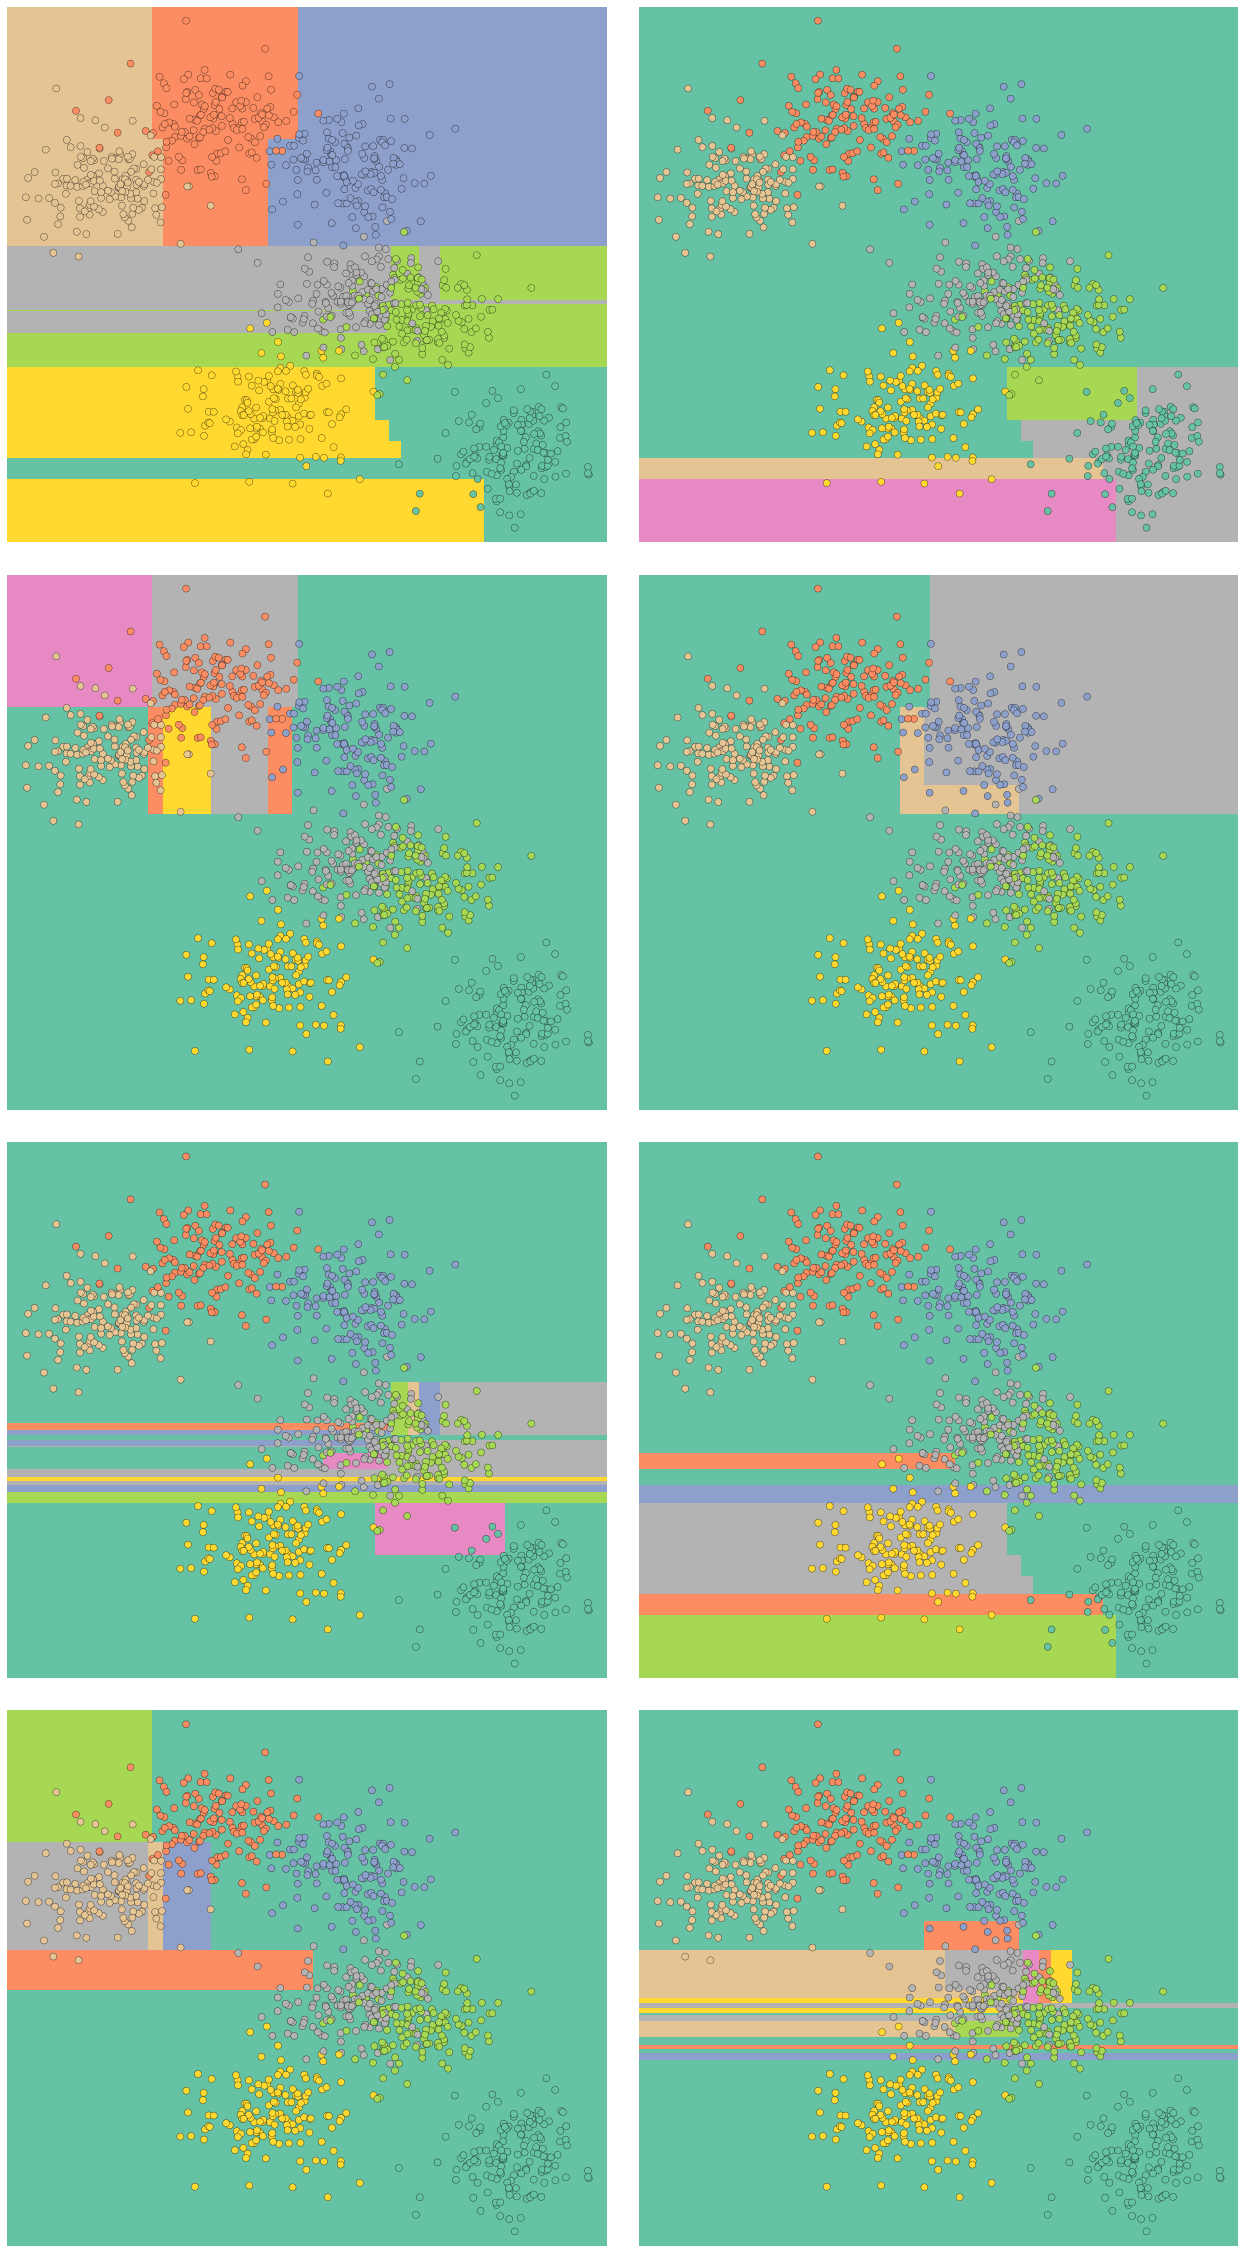

In [47]:
decision_tree_classifier(n_samples=1000, centers=7, min_samples_leaf=9, odds='odds')